In [6]:
import pandas as pd

# Load your dataset (update path if needed)
df = pd.read_csv('/kaggle/input/deceptive-opinion-spam-corpus/deceptive-opinion.csv')

# Keep only the 3 relevant columns
df = df[['text', 'deceptive', 'polarity']]

# Map labels to binary: 1 = deceptive, 0 = truthful
df['label'] = df['deceptive'].map({'deceptive': 1, 'truthful': 0})

# (Optional) Map polarity: positive = 1, negative = 0
df['polarity'] = df['polarity'].map({'positive': 1, 'negative': 0})

# Drop rows with missing values (if any)




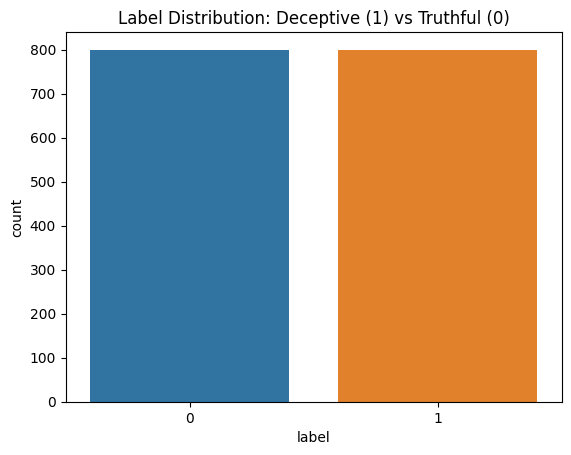

label
0    800
1    800
Name: count, dtype: int64


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='label', data=df)
plt.title("Label Distribution: Deceptive (1) vs Truthful (0)")
plt.show()

# Print actual numbers
print(df['label'].value_counts())


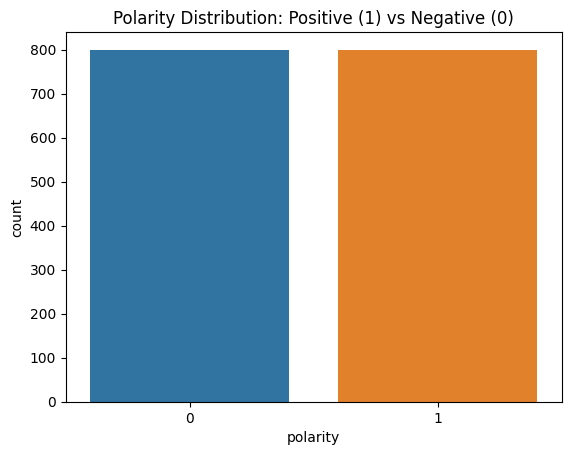

polarity
1    800
0    800
Name: count, dtype: int64


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check polarity distribution
sns.countplot(x='polarity', data=df)
plt.title("Polarity Distribution: Positive (1) vs Negative (0)")
plt.show()

print(df['polarity'].value_counts())


In [9]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)



In [10]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)


In [11]:
import torch

class DeceptiveDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}
    
    def __len__(self):
        return len(self.labels)

train_dataset = DeceptiveDataset(train_encodings, train_labels)
val_dataset = DeceptiveDataset(val_encodings, val_labels)


In [18]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    logging_dir='./logs',
    logging_steps=10,
)
from transformers import TrainerCallback

class LoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            print(f">>> Step {state.global_step}: {logs}")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[LoggingCallback()]
)

import os
os.environ["WANDB_DISABLED"] = "true"


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [19]:

trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,0.690800
20,0.691000
30,0.652700
40,0.631700
50,0.546600
60,0.482600
70,0.445400
80,0.445400
90,0.300100
100,0.246400


>>> Step 10: {'loss': 0.6908, 'grad_norm': 3.8400824069976807, 'learning_rate': 4.5e-06, 'epoch': 0.125}
>>> Step 20: {'loss': 0.691, 'grad_norm': 2.4492392539978027, 'learning_rate': 9.5e-06, 'epoch': 0.25}
>>> Step 30: {'loss': 0.6527, 'grad_norm': 3.4954674243927, 'learning_rate': 1.45e-05, 'epoch': 0.375}
>>> Step 40: {'loss': 0.6317, 'grad_norm': 10.576343536376953, 'learning_rate': 1.9500000000000003e-05, 'epoch': 0.5}
>>> Step 50: {'loss': 0.5466, 'grad_norm': 10.314163208007812, 'learning_rate': 2.45e-05, 'epoch': 0.625}
>>> Step 60: {'loss': 0.4826, 'grad_norm': 5.302831172943115, 'learning_rate': 2.95e-05, 'epoch': 0.75}
>>> Step 70: {'loss': 0.4454, 'grad_norm': 7.670785903930664, 'learning_rate': 3.45e-05, 'epoch': 0.875}
>>> Step 80: {'loss': 0.4454, 'grad_norm': 6.673521518707275, 'learning_rate': 3.9500000000000005e-05, 'epoch': 1.0}
>>> Step 90: {'loss': 0.3001, 'grad_norm': 6.6975998878479, 'learning_rate': 4.4500000000000004e-05, 'epoch': 1.125}
>>> Step 100: {'loss':

TrainOutput(global_step=240, training_loss=0.30903183395663897, metrics={'train_runtime': 114.8723, 'train_samples_per_second': 33.428, 'train_steps_per_second': 2.089, 'total_flos': 505173226291200.0, 'train_loss': 0.30903183395663897, 'epoch': 3.0})

In [20]:
trainer.evaluate()


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


>>> Step 240: {'eval_loss': 0.4978521466255188, 'eval_runtime': 3.0717, 'eval_samples_per_second': 104.178, 'eval_steps_per_second': 6.511, 'epoch': 3.0}


{'eval_loss': 0.4978521466255188,
 'eval_runtime': 3.0717,
 'eval_samples_per_second': 104.178,
 'eval_steps_per_second': 6.511,
 'epoch': 3.0}

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on validation set
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# Classification report
print(classification_report(labels, preds, target_names=["truthful", "deceptive"]))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(labels, preds))


              precision    recall  f1-score   support

    truthful       0.93      0.82      0.87       168
   deceptive       0.82      0.93      0.87       152

    accuracy                           0.87       320
   macro avg       0.88      0.87      0.87       320
weighted avg       0.88      0.87      0.87       320

Confusion Matrix:
[[138  30]
 [ 11 141]]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


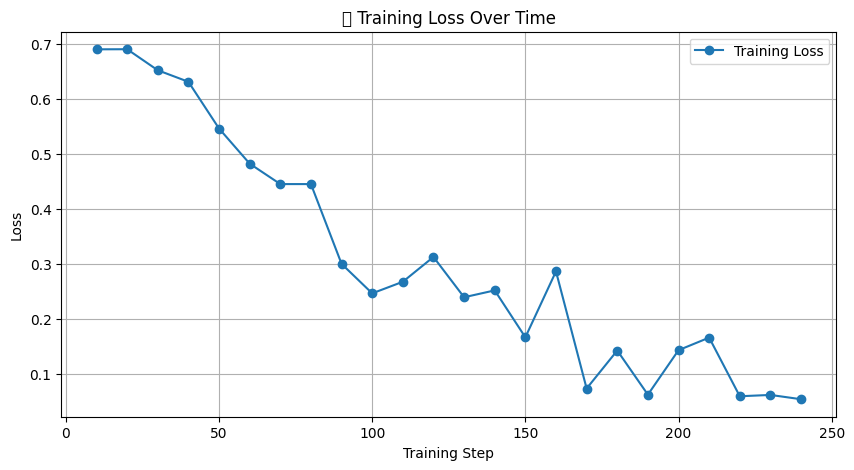

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

logs = trainer.state.log_history
df = pd.DataFrame(logs)
df = df[df['loss'].notna()]

plt.figure(figsize=(10,5))
plt.plot(df['step'], df['loss'], marker='o', label='Training Loss')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("📉 Training Loss Over Time")
plt.grid(True)
plt.legend()
plt.show()


<Figure size 600x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


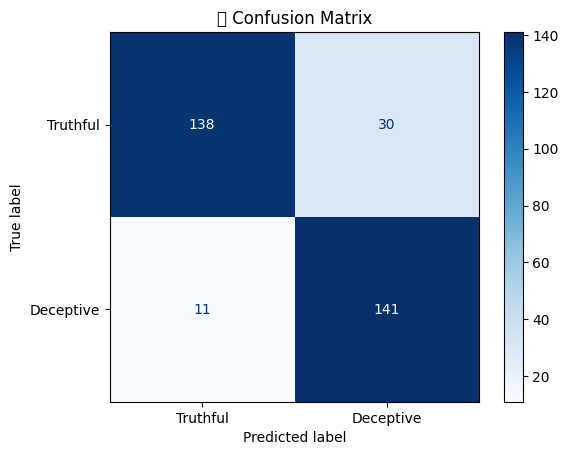

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Truthful", "Deceptive"])

plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("🔍 Confusion Matrix")
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


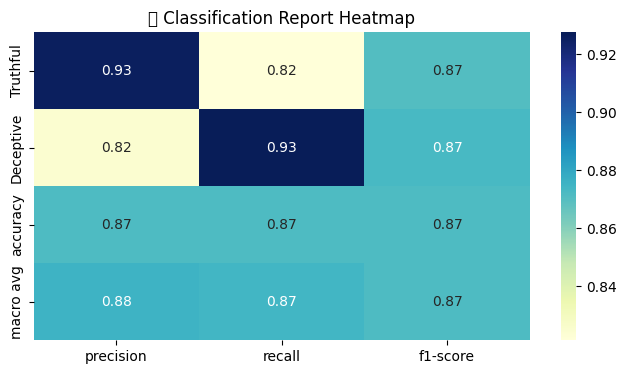

In [27]:
from sklearn.metrics import classification_report
import seaborn as sns

report = classification_report(labels, preds, output_dict=True, target_names=["Truthful", "Deceptive"])
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8,4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title("📊 Classification Report Heatmap")
plt.show()


In [28]:
model.save_pretrained("./deception-bert")
tokenizer.save_pretrained("./deception-bert")


('./deception-bert/tokenizer_config.json',
 './deception-bert/special_tokens_map.json',
 './deception-bert/vocab.txt',
 './deception-bert/added_tokens.json')